In [1]:
import os

file_name = os.path.join('jena_climate_2009_2016.csv')

with open(file_name) as file:
    data = file.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))
    

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

In [3]:
temperature.shape

(420451,)

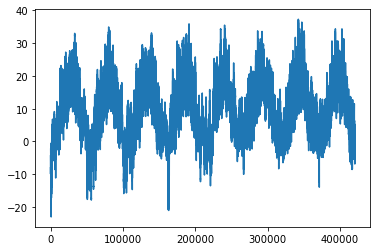

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)),temperature)

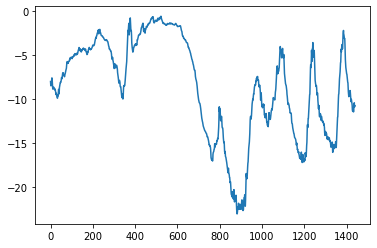

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(.5 * len(raw_data))
num_val_samples = int(.25 * len(raw_data))
num_test_samples = len(raw_data) - num_val_samples - num_train_samples

print(f"num_train {num_train_samples} ")
print(f"num_val {num_val_samples} ")
print(f"num_test {num_test_samples} ")

num_train 210225 
num_val 105112 
num_test 105114 


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std_deviation = raw_data[:num_train_samples].std(axis=0)
raw_data /= std_deviation

In [8]:
raw_data.shape

(420451, 14)

In [9]:
raw_data.max()

8.818020059317446

In [10]:
sampling_rate = 6
sequence_length = 120

delay = sampling_rate * (sequence_length + 24  - 1)
batch_size = 256

from keras.utils import timeseries_dataset_from_array


In [11]:

train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

2022-09-07 21:06:13.487939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 21:06:13.551614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 21:06:13.552414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 21:06:13.556635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

In [13]:
test_dataset = timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples)

The data is recorded every ten minutes. So 144 data points per day

In [14]:
for samples, targets in train_dataset:
    print("Samples shape: ", samples.shape)
    print("Targets shape: ", targets.shape)
    break

Samples shape:  (256, 120, 14)
Targets shape:  (256,)


A common sens, ML baseline. Let's evaluate with a simple common-sense approach.

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    
    for samples, targets in dataset:
        preds = samples[: ,-1, 1] * std_deviation[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset)} ")
print(f"Test MAE: {evaluate_naive_method(test_dataset)} ")

Validation MAE: 2.4417357485655167 
Test MAE: 2.6218984517612074 


Now, let's try basic ML Mdodel

In [16]:
import keras
from keras import layers

inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

raw_data.shape

(420451, 14)

In [17]:
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = "relu")(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs = 10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]} ")

Epoch 1/10
819/819 [==============================] - 11s 12ms/step - loss: 12.0167 - mae: 2.6910 - val_loss: 11.2312 - val_mae: 2.6630
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 8.7974 - mae: 2.3308 - val_loss: 10.8854 - val_mae: 2.6025
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 8.0363 - mae: 2.2261 - val_loss: 11.0636 - val_mae: 2.6369
Epoch 4/10
819/819 [==============================] - 10s 13ms/step - loss: 7.6193 - mae: 2.1642 - val_loss: 11.8610 - val_mae: 2.7148
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.3335 - mae: 2.1283 - val_loss: 10.7358 - val_mae: 2.5794
Epoch 6/10
819/819 [==============================] - 10s 13ms/step - loss: 7.1272 - mae: 2.0977 - val_loss: 11.1694 - val_mae: 2.6293
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 6.9642 - mae: 2.0725 - val_loss: 11.8071 - val_mae: 2.7071
Epoch 8/10
819/819 [==============================] - 

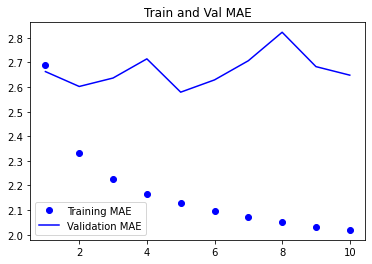

In [18]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Train and Val MAE")
plt.legend()
plt.show()

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",
save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-09-07 21:08:12.747371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-07 21:08:14.482662: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 21:08:14.483292: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 21:08:14.483314: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-07 21:08:14.483950: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 21:08:14.484002: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


819/819 [==============================] - 15s 14ms/step - loss: 24.0251 - mae: 3.8661 - val_loss: 21.8627 - val_mae: 3.6613
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 19.4833 - mae: 3.5074 - val_loss: 18.7132 - val_mae: 3.4146
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 18.3941 - mae: 3.4077 - val_loss: 21.8820 - val_mae: 3.6506
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 17.6480 - mae: 3.3388 - val_loss: 22.6376 - val_mae: 3.6990
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 17.1284 - mae: 3.2895 - val_loss: 18.6927 - val_mae: 3.4366
Epoch 6/10
819/819 [==============================] - 16s 20ms/step - loss: 16.6987 - mae: 3.2474 - val_loss: 20.0881 - val_mae: 3.5770
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 16.3456 - mae: 3.2126 - val_loss: 19.4081 - val_mae: 3.5185
Epoch 8/10
819/819 [==============================] - 16s 1

First recurrent baseline

In [21]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 48.3380 - mae: 5.0806 - val_loss: 14.0077 - val_mae: 2.8245
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 11.2051 - mae: 2.6010 - val_loss: 9.5779 - val_mae: 2.4139
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 9.7672 - mae: 2.4345 - val_loss: 9.7279 - val_mae: 2.4178
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 9.2711 - mae: 2.3690 - val_loss: 9.5326 - val_mae: 2.4049
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 8.8894 - mae: 2.3190 - val_loss: 9.8570 - val_mae: 2.4347
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 8.6212 - mae: 2.2828 - val_loss: 9.8969 - val_mae: 2.4407
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 8.3816 - mae: 2.2508 - val_loss: 9.9590 - val_mae: 2.4344
Epoch 8/10
819/819 [==============================] - 13s 1